# VCディスク(Amazon EBS)を利用したVCノードの起動、削除、再起動

## VCディスクについて

VCPでは計算資源の操作だけではなく、外付けディスク（[Amazon EBS](https://aws.amazon.com/jp/ebs/), [Microsoft Azure Managed Disks](https://azure.microsoft.com/ja-jp/services/storage/disks/), ...）を生成、削除する機能があります。VCPによって、生成されたディスクをVCディスクと呼んでいます。

通常、外付けディスクのライフサイクルは計算資源（VCノード）とは異なるので、VCディスクとVCノードは別々のUnitGroupとして扱います。

## 構成

このNotebookで構築するVCノード, VCディスクの構成を以下の図に示します。

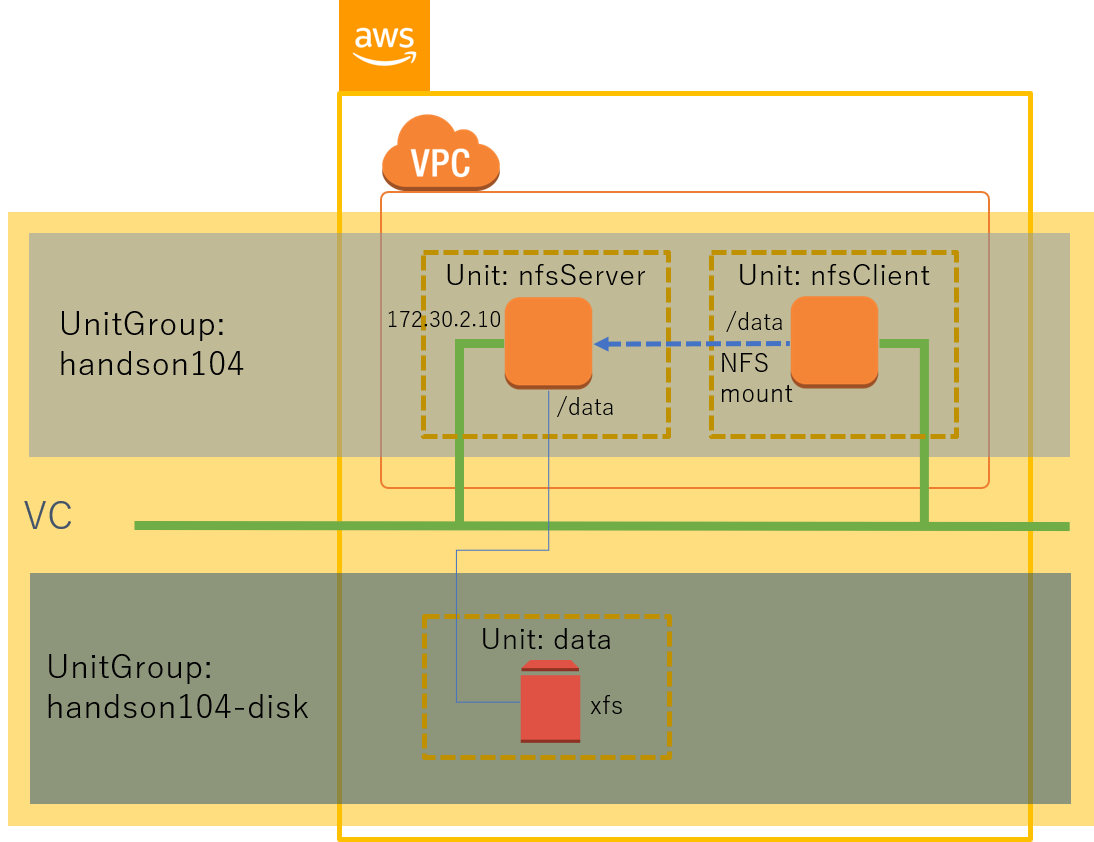

* UnitGroup: handson104
  * VCノード(Amazon EC2インスタンス)で構成されるUnitGroup
  * ２つのUnit(nfsServer, nfsClient)で構成されている
    * Unit: nfsServer
      - NFSサーバとなる VCノードで構成されているUnit
      - VC:handson104-disk の VCディスク がアタッチされる
      - 事前に設定したIPアドレスが割り当てられる
      - NFSサーバ用のBaseコンテナイメージを利用する
    * Unit: nfsClient
      - NFSクライアントとなる VCノードで構成されているUnit
* UnitGroup: handson104-disk
  * VCディスク(Amazon EBS)で構成されるUnitGroup
  * １つのUnit(data)で構成されている
    * Unit: data
      - NFS公開用ディスクとなる VCディスクで構成されているUnit
      - Unit:nfsServer の VCノードにアタッチされる

## 操作手順

この Notebook での大まかな操作手順は以下のようになります。

1. VCP SDKを用いてVCディスク(Amazon EBS)を作成する
1. 作成したVCディスクをアタッチしたVCノード(Amazon EC2インスタンス)を起動する
1. VCディスクにファイルシステムを作成しNFSサーバで公開する
1. NFSで公開されているディレクトリを他のVCノードからNFSマウントして、ファイルの読み書きを行う
1. VCノードを全て削除する
1. VCディスクをアタッチしたVCノードを新たに起動して、先ほど書き込んだファイルにアクセスできることを確認する

# ディスクの作成

VCP SDKでVCディスク(Amazon EBS)を作成します。

この節を実行すると次図の状態になります。

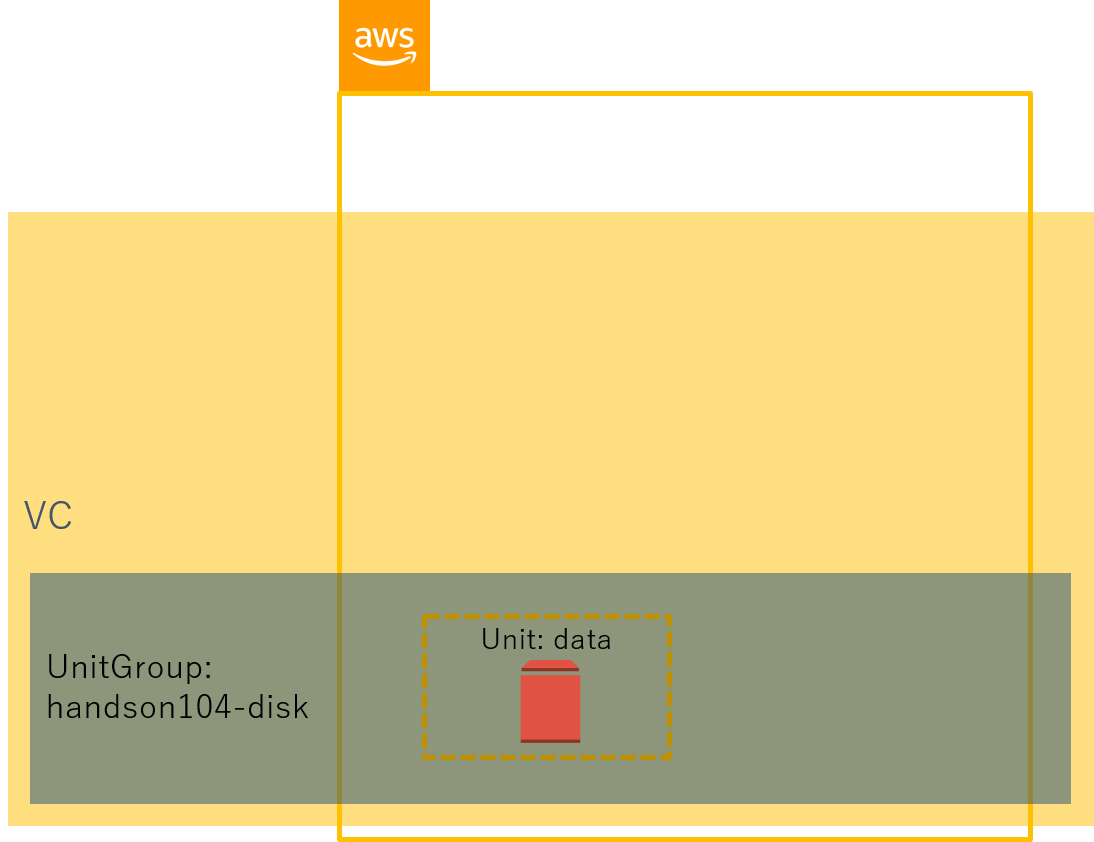

VCディスクの作成手順は基本的に VCノードの作成手順と同じですが、以下の点が異なります。

* UnitGroupを作成するときに`ugroup_type`パラメータを`storage`と指定します
* flavor の定義に用いるプロバイダ名はサフィックスに `_disk`を付ける命名規則になっています。例えば
  - `aws` の 場合は、`aws_disk`
  - `azure` の場合は `azure_disk`

## アクセストークンの入力

VCP SDKを利用するにはVC Controllerのアクセストークンが必要となります。

次のセルを実行すると表示される入力枠にVC Controllerのアクセストークンの値を入力してください。

In [1]:
from getpass import getpass
vcc_access_token = getpass()

········


## VCP SDKの初期化

VCP SDKの初期化を行います。

In [2]:
from common import logsetting
from vcpsdk.vcpsdk import VcpSDK

# 管理オブジェクトの作成
vcp = VcpSDK(
    vcc_access_token,    # VCCのアクセストークン
)

上のセルの実行結果がエラーとなり以下のようなメッセージが表示されている場合は、入力されたアクセストークンに誤りがあります。

```
2018-09-XX XX:XX:XX,XXX - ERROR - config vc failed: http_status(403)
2018-09-XX XX:XX:XX,XXX - ERROR - 2018/XX/XX XX:XX:XX UTC: VCPAuthException: xxxxxxx:token lookup is failed: permission denied
```

この場合はアクセストークンの入力からやり直してください。

## UnitGroupの作成

VCディスクのための UnitGroupを作成します。

VCノード用のUnitGroupと異なり、`ugroup_type`パラメータに `storage` を指定する必要があります。

In [3]:
ugroup_disk = vcp.create_ugroup(
    'handson104-disk',       # UnitGroupの名前
    ugroup_type='storage'    # UnitGroupの種別を指定する
)

UnitGroupの一覧を表示してみます。

> UnitGroup`handson104-disk` のタイプが `storage` であることが確認できます。

In [4]:
# UnitGroupの一覧を DataFrame で表示する
vcp.df_ugroups()

,vcno,vctype,vcname,state,vcid,cdate
0,39,storage,handson104-disk,RUNNING,9a906c6d...,2018/09/28 06:29:02 UTC


## UnitGroupの状態を確認する

UnitGroup `handson104-disk` にまだ Unit, VCディスク が作成されていないことを確認します。

In [5]:
from IPython.display import display

# Unitの一覧を DataFrame で表示する
display(ugroup_disk.df_units())

# VCディスクの一覧を DataFrame で表示する
display(ugroup_disk.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


None

## VCディスクのspecを指定する

### flavor

VCノードの場合と同様、VCディスクについても典型的な構成のパラメータセットを flavor として定義しています。

aws用に定義しているVCディスクの flavor 定義の一覧を表示してみます。

In [6]:
VcpSDK.df_flavors('aws_disk')

,flavor,size,type
0,small,8,standard
1,medium,32,standard
2,large,128,standard


### spec オブジェクトを作成する

specオブジェクトを作成します。

specオブジェクトを作成するにはプロバイダと`flavor`を指定します。ここでは以下の値を指定します。

* プロバイダ: `aws_disk`
* flavor: `small`


> VCディスクのプロバイダ名にはサフィックスに `_disk`を付ける命名規則になっています。

In [7]:
spec_disk = VcpSDK.get_spec('aws_disk', 'small')

### specの設定内容の確認

`spec` オブジェクトの設定内容を確認してみます。

> `flavor` の指定に対応する値が `size`, `type`に 設定されていることが確認できます。

In [8]:
print(spec_disk)


aws_disk
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_disks: 1
    size: 8
    type: standard
    cloud_image: default
    tags: {}


`spec`オブジェクトに対しては、以下のようなパラメータを指定することもできます。

* num_disks
  - Unit内に作成するVCディスクの数: デフォルト=1
* type
  - Amazon EBSのタイプ
  - flavorで設定されているもの以外を利用したい場合に指定する
* size
  - Amazon EBSのサイズ(GiB)
  - flavorで設定されているもの以外を利用したい場合に指定する

## Unitの作成とVCディスクの作成

Unitを作成します。同時に VCディスク（ここでは Amazon EBS）が作成されます。

> 処理が完了するまで20～30秒程度かかります。

In [9]:
# Unitの作成（同時に VCディスクが作成される）
ugroup_disk.create_unit('data', spec_disk)

2018-09-28 15:31:02,760 - INFO - CREATING ... 0 sec
2018-09-28 15:31:07,926 - INFO - CREATING ... 5 sec
2018-09-28 15:31:13,100 - INFO - CREATING ... 10 sec
2018-09-28 15:31:18,268 - INFO - CREATING ... 15 sec
2018-09-28 15:31:23,433 - INFO - unit data is RUNNING


現在の Unit, VCディスク の一覧を表示します。

In [10]:
# Unitの一覧を DataFrame で表示する
display(ugroup_disk.df_units())

# VCディスクの一覧を DataFrame で表示する
display(ugroup_disk.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,storage,39,handson104-disk,RUNNING,9a906c6d...,2018/09/28 06:29:02 UTC,data,RUNNING


,vcno,vcname,unit_name,unit_state,disk_no,disk_id,node_state,cloud_disk_id,cloud_disk_size
0,39,handson104-disk,data,RUNNING,1,b30a4472...,RUNNING,vol-05352d9eb7355cdd7,8


# NFSサーバ用VCノードの起動

NFSサーバ用のVCノードを起動します。

この節を実行すると次図の状態になります。

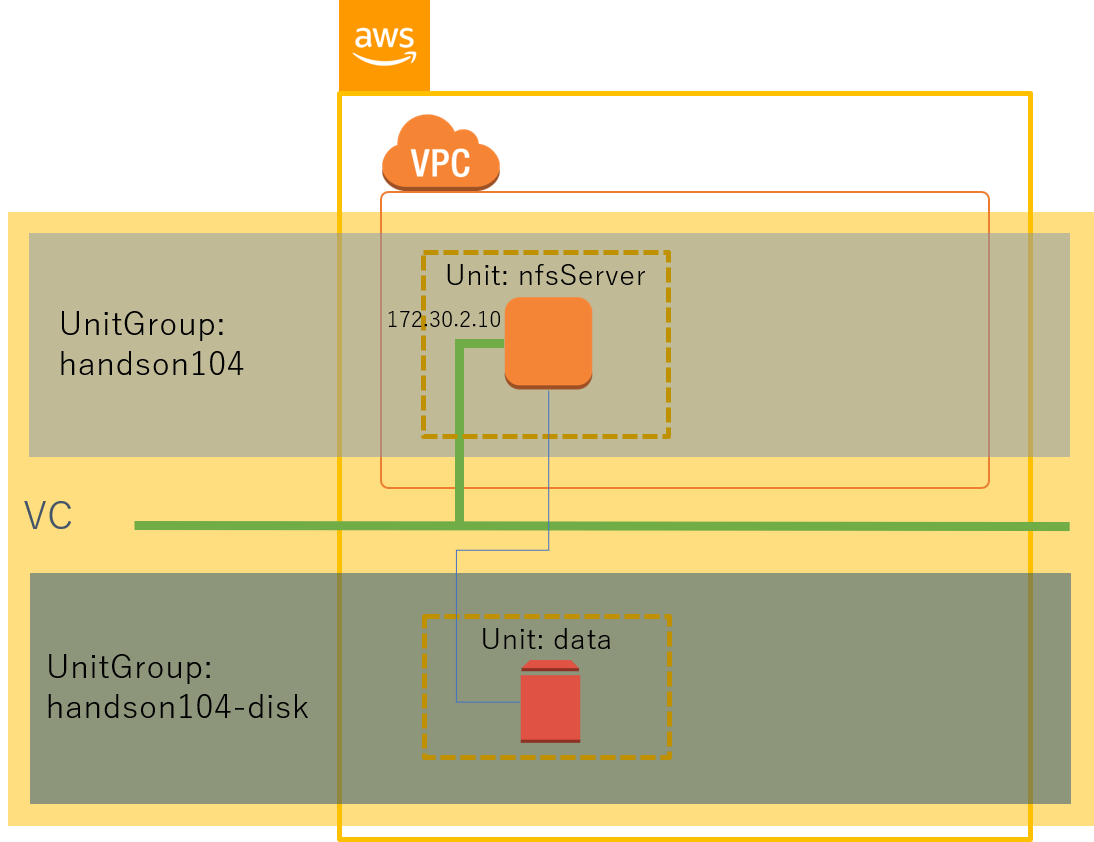

## UnitGroupの作成

VCノードのためのUnitGroupを作成します。

In [11]:
unit_group = vcp.create_ugroup(
    'handson104'       # UnitGroupの名前
)

UnitGroupの一覧を表示してみます。

In [12]:
vcp.df_ugroups()

,vcno,vctype,vcname,state,vcid,cdate
0,39,storage,handson104-disk,RUNNING,9a906c6d...,2018/09/28 06:29:02 UTC
1,40,compute,handson104,RUNNING,37f7d717...,2018/09/28 06:30:31 UTC


Unit Group `handson104` にまだ Unit, VCノードが作成されていないことを確認します。

In [13]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# VCノードの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


None

## VCノードのspecを指定する

NFSサーバ用の`spec`を指定します。

NFSサーバ用の`spec`ではSSHの公開鍵認証の設定に加えて、以下の設定を行います。

* 事前に定めたIPアドレスを割り当てる
* `handson104-disk` の VCディスクをアタッチする
* NFSサーバ用のBaseコンテナに関する設定を行う

### spec オブジェクトを作成する

specオブジェクトを作成します。ここでは以下の値を指定します。

* プロバイダ: `aws`
* flavor: `small`。

In [14]:
spec_server = VcpSDK.get_spec('aws', 'small')

### sshの鍵ファイルを設定する

VCノードにsshでログインするための秘密鍵のパスを設定します。

In [15]:
import os
ssh_private_key = os.path.expanduser('~/.ssh/id_rsa')

spec に設定が必要となるのは公開鍵なので `ssh-keygen -y` コマンドで秘密鍵から公開鍵を取り出します。さらに公開鍵を`spec`が要求するフォーマット(Base64)に変換して `spec` オブジェクトに設定します。

In [16]:
out = !ssh-keygen -y -f {ssh_private_key} | base64 -w 0
b64_ssh_public_key = out[0]
spec_server.params_e.append('AUTHORIZED_KEYS={}'.format(b64_ssh_public_key))

### VCノードのIPアドレスを設定する

NFSサーバに固定のIPアドレスを割り当てるための設定を `spec` に行います。次のセルの `server_ip_address`にNFSサーバに割り当てる IPアドレスを指定してください。

> 割り当て可能な IP アドレスの範囲は[VCP Manager Web UI](https://tokyo01.vcloud.nii.ac.jp/vcp/v1/ui/occmgr/menu/occtrs) から取得することができます。

In [17]:
# NFSサーバのIPアドレス
server_ip_address = '172.30.2.10'

# spec_server にIPアドレスを設定する
spec_server.ip_address_list = [server_ip_address]

### VCディスクをアタッチする

VCディスクをVCノードにアタッチするには(Amazon EBSの)ボリュームIDを`spec`オブジェクトに設定する必要があります。

VCディスクのボリュームIDを取得します。

In [18]:
# VCディスクのボリュームIDを取得する
volume_id = ugroup_disk.find_nodes(mapper=lambda x: x.cloud_disk_id)

print(volume_id)

['vol-05352d9eb7355cdd7']


取得したボリュームIDのリストを `spec.volume_id` に設定します。リストに複数のボリュームIDを指定した場合は対応する全てのVCディスクが一つのVCノードにアタッチされます。

> VCノードにディスクをアタッチするように設定した場合は Unit に複数の VCノードを作成することが出来なくなります。

In [19]:
spec_server.volume_id = volume_id

> ここではVCディスクオブジェクトのリストからAmazon EBSのボリュームIDを取得してその値を`spec.volume_id`に設定しました。VCディスクのオブジェクトのリストを直接`spec.volume_id`に設定することもできます。詳しくはVCP SDKの説明資料を参照してください。

### NFSサーバ用のBaseコンテナに関する設定を行う

これまでの例ではBaseコンテナには標準のコンテナイメージを利用していました。今回起動するVCノードではNFSサーバ用のBaseコンテナイメージを利用します。まず`spec`オブジェクトにNFSサーバ用のコンテナイメージの指定を行います。

In [20]:
# NFSサーバ用のコンテナイメージを設定する
spec_server.image = 'nfsd'

Baseコンテナには `spec.params_e` に設定した値を環境変数として受け渡すことができます。これを利用してBaseコンテナの動作や設定値を変更することができます。パラメータの役割を担う環境変数はいくつかありますが、最もよく用いるのはVCノードにsshの公開鍵を登録するための`AUTHORIZED_KEYS`です。

どのような環境変数がパラメータの役割を担うのかはコンテナイメージ毎に異なります。NFSサーバ用のコンテナイメージで指定可能なパラメータを以下に記します。

* NFS_DOMAIN
  - 指定された値をNFSドメインとして設定ファイル(/etc/idmapd.conf)に反映する
* ETC_EXPORTS
  - 指定された値を/etc/exportsに反映する。ただしbase64エンコードした値を指定する必要がある
* ETC_FSTAB
  - 指定された値を/etc/fstabに反映する。ただしbase64エンコードした値を指定する必要がある
* MKDIR_LIST
  - 指定されたディレクトリを起動時に作成する
  - 複数のディレクトリを指定する場合は `:` で区切る
  - 事前に作成することが必要となるマウントポイントなどのディレクトリを指定する
  
ここでは NFSドメインの設定のみ行います。

In [21]:
# NFSドメインの設定
nfs_domain = 'vcp-handson.org'

spec_server.params_e.append('NFS_DOMAIN={}'.format(nfs_domain))

### specの設定内容の確認

ここまで `spec` オブジェクトに設定した内容を確認してみます。

In [22]:
print(spec_server)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: nfsd
    recovery_mode: none
    params:
        {'v': [], 'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK', 'NFS_DOMAIN=vcp-handson.org']}
    instance_type: m4.large
    volume_size: 20
    volume_type: standard
    volume_id: ['vol-05352d9eb7355cdd7']
    cloud_image: default
    tags: {}


## Unitの作成とVCノードの起動

起動前のUnit, VCノードの状態を確認しておきます。

In [23]:
from IPython.display import display

# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


None

Unitの作成とVCノードの起動を行います。

> 処理が完了するまで1分半～2分程度かかります。

In [24]:
# Unitの作成（同時に VCノードが作成される）
unit_server = unit_group.create_unit('nfsServer', spec_server)

2018-09-28 15:31:54,084 - INFO - BOOTING ... 0 sec
2018-09-28 15:31:59,294 - INFO - BOOTING ... 5 sec
2018-09-28 15:32:04,490 - INFO - BOOTING ... 10 sec
2018-09-28 15:32:09,711 - INFO - BOOTING ... 15 sec
2018-09-28 15:32:14,917 - INFO - BOOTING ... 20 sec
2018-09-28 15:32:20,126 - INFO - BOOTING ... 25 sec
2018-09-28 15:32:25,339 - INFO - BOOTING ... 30 sec
2018-09-28 15:32:30,547 - INFO - BOOTING ... 35 sec
2018-09-28 15:32:35,750 - INFO - BOOTING ... 40 sec
2018-09-28 15:32:40,948 - INFO - BOOTING ... 45 sec
2018-09-28 15:32:46,141 - INFO - BOOTING ... 50 sec
2018-09-28 15:32:51,342 - INFO - BOOTING ... 55 sec
2018-09-28 15:32:56,537 - INFO - BOOTING ... 60 sec
2018-09-28 15:33:01,739 - INFO - BOOTING ... 65 sec
2018-09-28 15:33:06,934 - INFO - BOOTING ... 70 sec
2018-09-28 15:33:12,154 - INFO - BOOTING ... 75 sec
2018-09-28 15:33:17,358 - INFO - BOOTING ... 80 sec
2018-09-28 15:33:22,572 - INFO - BOOTING ... 85 sec
2018-09-28 15:33:27,787 - INFO - unit nfsServer is RUNNING


起動したUnit, VCノードの一覧を表示します。

In [25]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,40,handson104,RUNNING,37f7d717...,2018/09/28 06:30:31 UTC,nfsServer,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,40,handson104,nfsServer,RUNNING,1,672226cc...,RUNNING,172.30.2.10,i-0071f4bf83ff9d223,VCP-020661f0-37f7d717,exists


起動したVCノード に対して `ping` を行ってみます。

In [26]:
!ping -c 5 {server_ip_address}

PING 172.30.2.10 (172.30.2.10): 56 data bytes
64 bytes from 172.30.2.10: icmp_seq=2 ttl=63 time=0.332 ms
64 bytes from 172.30.2.10: icmp_seq=3 ttl=63 time=0.282 ms
64 bytes from 172.30.2.10: icmp_seq=4 ttl=63 time=0.288 ms
--- 172.30.2.10 ping statistics ---
5 packets transmitted, 3 packets received, 40% packet loss
round-trip min/avg/max/stddev = 0.282/0.301/0.332/0.000 ms


## Ansible の設定

VCノードの操作には [Ansible](https://www.ansible.com/) を用いるので、その設定を行います。

まず、起動したVCノードのIPアドレスをインベントリに登録します。グループ名は Unit名に合わせて `nfsServer`とします。

In [27]:
# ./hosts に追記する
with open('hosts', 'a') as f:
    f.write("[{}]\n".format(unit_server.name))
    for addr in unit_server.find_ip_addresses():
        f.write("{}\n".format(addr))

# ./hosts の内容を表示する
!cat hosts

[nfsServer]
172.30.2.10


インベントリは次のセルを実行すると表示されるリンクからも編集することができます。

In [28]:
%run scripts/nbutils.py
nb_html_link(os.path.abspath('hosts'), 'インベントリ')

カレントディレクトリの `hosts`ファイルをインベントリとして Ansible が認識するようにする設定を `ansible.cfg`に書き込みます。

In [29]:
if not os.path.exists('ansible.cfg'):
    # ansible.cfgが存在しない場合のみ作成する
    with open('ansible.cfg', 'w') as f:
        f.write('''[defaults]
inventory = {}
'''.format(os.path.abspath('./hosts')))
    
!cat ansible.cfg

[defaults]
inventory = /notebooks/notebook/handson/vcp-tutorial/hosts


VCノードに接続する際のsshの設定を Ansible の変数ファイルに格納しておきます。

In [30]:
import yaml

# ansibleでVCノードに接続する際の設定
ansible_params = {
    'ansible_user': 'root',
    'ansible_ssh_extra_args': '-o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null',
    'ansible_ssh_private_key_file': os.path.abspath(ssh_private_key),
}

# group_vars への書き込み
!mkdir -p group_vars
vc_group_vars = os.path.abspath('group_vars/{}.yml'.format(unit_server.name))
with open(vc_group_vars, 'w') as f:
    yaml.dump(ansible_params, stream=f, default_flow_style=False)

!cat {vc_group_vars}

ansible_ssh_extra_args: -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null
ansible_ssh_private_key_file: /home/bit_kun/.ssh/id_rsa
ansible_user: root


Ansible で VCノードに接続できるか確認します。

In [31]:
!ansible {unit_server.name} -m ping

172.30.2.10 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


# NFSクライアント用VCノードの起動

NFSクライアント用のVCノードを起動します。

この節を実行すると次図の状態になります。

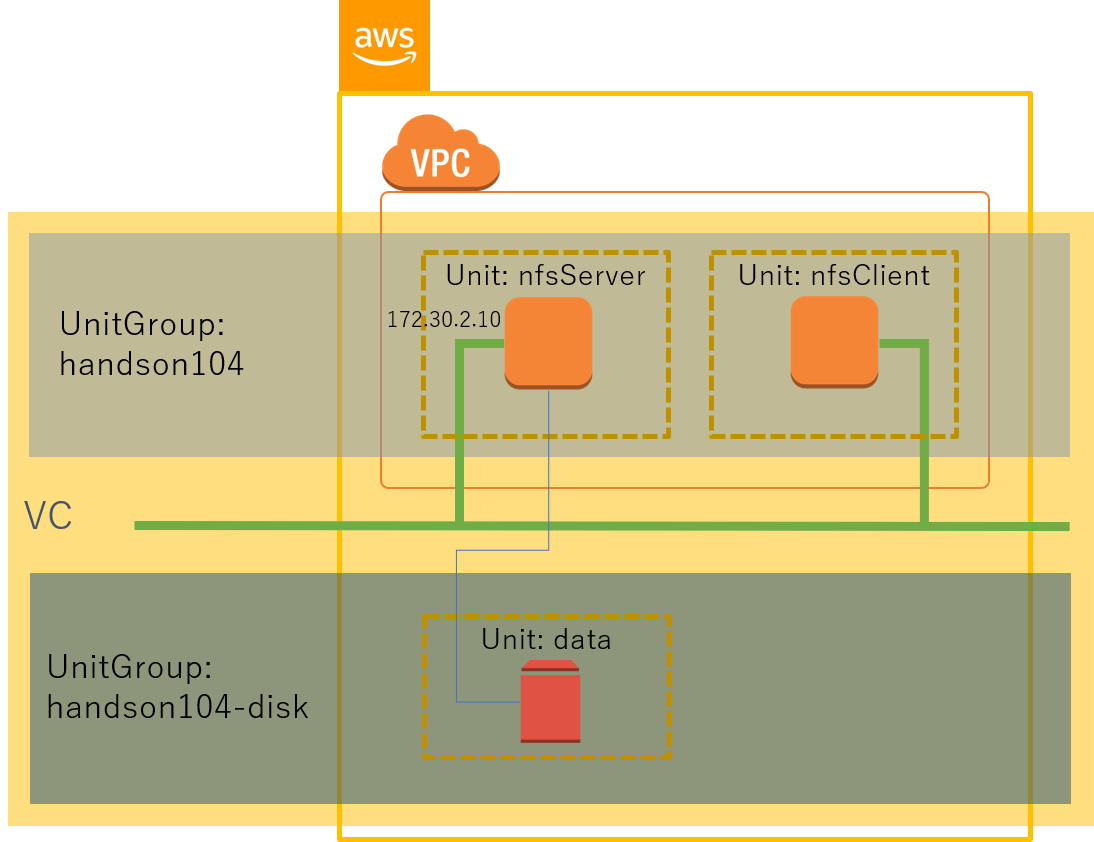

## VCノードのspecを指定する

NFSクライアント用の`spec`を指定します。

VCディスクをアタッチしない、NFSサーバの設定を行わない等、NFSサーバ用のVCノードとは設定が異なるので新たなUnitを作成します。このUnitではsshの公開鍵認証の設定のみ行います。

### spec オブジェクトを作成する

NFSクライアント用のspecオブジェクトを作成します。ここでは以下の値を指定します。

* プロバイダ: `aws`
* flavor: `small`

In [32]:
spec_client = VcpSDK.get_spec('aws', 'small')

### sshの鍵ファイルを設定する

VCノードに登録するsshの公開鍵を `spec`オブジェクトに設定します。先ほどNFSサーバ用Unitで設定したのと同じ値を指定しています。

In [33]:
spec_client.params_e.append('AUTHORIZED_KEYS={}'.format(b64_ssh_public_key))

### specの設定内容の確認

`spec` オブジェクトの設定内容を確認してみます。

In [34]:
print(spec_client)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'v': [], 'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK']}
    instance_type: m4.large
    volume_size: 20
    volume_type: standard
    volume_id: []
    cloud_image: default
    tags: {}


## Unitの作成とVCノードの起動

起動前のUnit, Nodeの状態を確認しておきます。

In [35]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,40,handson104,RUNNING,37f7d717...,2018/09/28 06:30:31 UTC,nfsServer,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,40,handson104,nfsServer,RUNNING,1,672226cc...,RUNNING,172.30.2.10,i-0071f4bf83ff9d223,VCP-020661f0-37f7d717,exists


Unitの作成とVCノードの起動を行います。

> 処理が完了するまで1分半～2分程度かかります。

In [36]:
# Unitの作成（同時に VCノードが作成される）
unit_client = unit_group.create_unit('nfsClient', spec_client)

2018-09-28 15:33:59,175 - INFO - BOOTING ... 0 sec
2018-09-28 15:34:04,413 - INFO - BOOTING ... 5 sec
2018-09-28 15:34:09,653 - INFO - BOOTING ... 10 sec
2018-09-28 15:34:14,895 - INFO - BOOTING ... 15 sec
2018-09-28 15:34:20,139 - INFO - BOOTING ... 20 sec
2018-09-28 15:34:25,385 - INFO - BOOTING ... 25 sec
2018-09-28 15:34:30,634 - INFO - BOOTING ... 30 sec
2018-09-28 15:34:35,868 - INFO - BOOTING ... 35 sec
2018-09-28 15:34:41,116 - INFO - BOOTING ... 40 sec
2018-09-28 15:34:46,351 - INFO - BOOTING ... 45 sec
2018-09-28 15:34:51,802 - INFO - BOOTING ... 50 sec
2018-09-28 15:34:57,040 - INFO - BOOTING ... 55 sec
2018-09-28 15:35:02,298 - INFO - BOOTING ... 60 sec
2018-09-28 15:35:07,552 - INFO - BOOTING ... 65 sec
2018-09-28 15:35:12,811 - INFO - BOOTING ... 70 sec
2018-09-28 15:35:18,048 - INFO - unit nfsClient is RUNNING


起動したUnit, VCノードの一覧を表示します。

In [37]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,40,handson104,RUNNING,37f7d717...,2018/09/28 06:30:31 UTC,nfsServer,RUNNING
1,compute,40,handson104,RUNNING,37f7d717...,2018/09/28 06:30:31 UTC,nfsClient,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,40,handson104,nfsServer,RUNNING,1,672226cc...,RUNNING,172.30.2.10,i-0071f4bf83ff9d223,VCP-020661f0-37f7d717,exists
1,40,handson104,nfsClient,RUNNING,1,55083ca5...,RUNNING,172.30.2.143,i-053c86810a4798485,VCP-020661f0-37f7d717,none


## Ansible の設定

起動したVCノードのIPアドレスをインベントリに登録します。グループ名は Unit名に合わせて `nfsClient`とします。

In [38]:
# ./hosts に追記する
with open('hosts', 'a') as f:
    f.write("[{}]\n".format(unit_client.name))
    for addr in unit_client.find_ip_addresses():
        f.write("{}\n".format(addr))

# ./hosts の内容を表示する
!cat hosts

[nfsServer]
172.30.2.10
[nfsClient]
172.30.2.143


インベントリは次のセルを実行すると表示されるリンクからも編集することができます。

In [39]:
%run scripts/nbutils.py
nb_html_link(os.path.abspath('hosts'), 'インベントリ')

VCノードに接続する際のsshの設定を Ansible の変数ファイルに格納しておきます。

In [40]:
import yaml

# ansibleでVCノードに接続する際の設定
ansible_params = {
    'ansible_user': 'root',
    'ansible_ssh_extra_args': '-o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null',
    'ansible_ssh_private_key_file': os.path.abspath(ssh_private_key),
}

# group_vars への書き込み
!mkdir -p group_vars
vc_group_vars = os.path.abspath('group_vars/{}.yml'.format(unit_client.name))
with open(vc_group_vars, 'w') as f:
    yaml.dump(ansible_params, stream=f, default_flow_style=False)

!cat {vc_group_vars}

ansible_ssh_extra_args: -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null
ansible_ssh_private_key_file: /home/bit_kun/.ssh/id_rsa
ansible_user: root


Ansible で VCノードに接続できるか確認します。

In [41]:
!ansible {unit_client.name} -m ping

172.30.2.143 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


# NFSサーバの設定

VCディスクをNFSサーバで公開するための設定を行います。

この節を実行すると次図の状態になります。

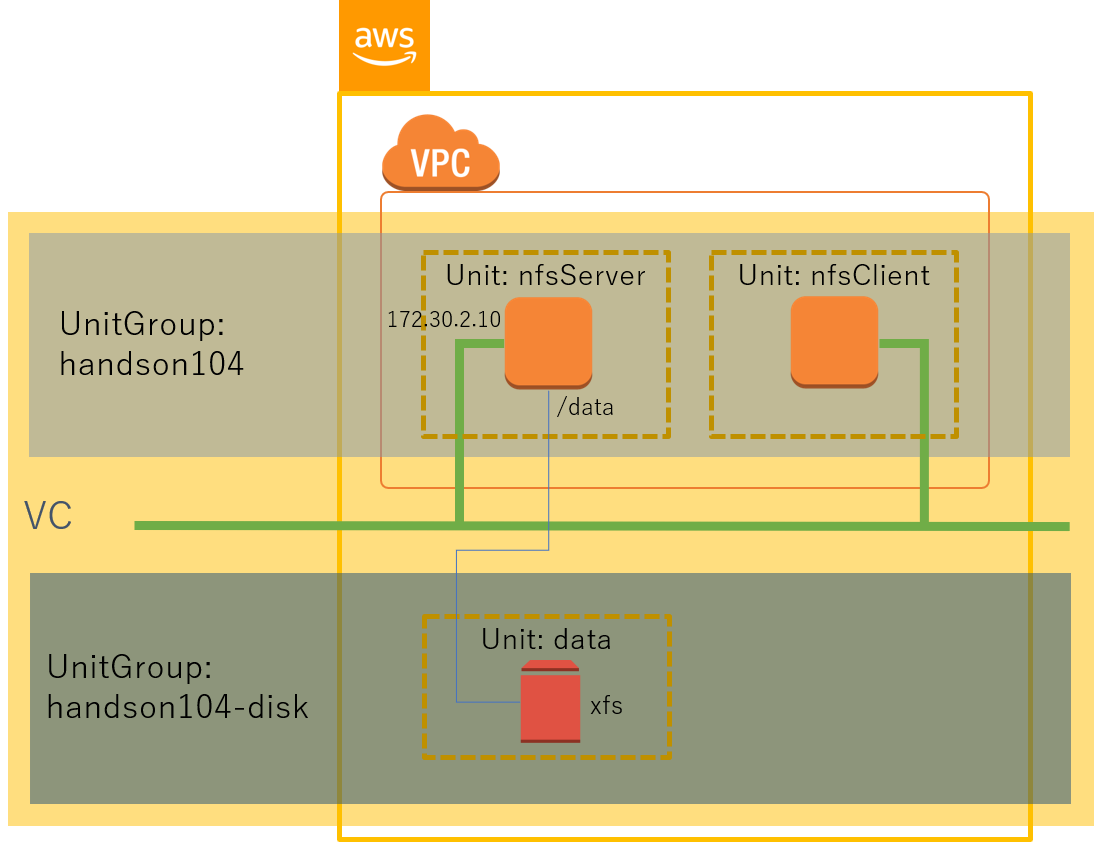

主な手順は以下のようになります。

1. VCディスクにファイルシステム(xfs)を作成する
1. VCディスクをマウントする
1. マウントしたディレクトリをNFSサーバの公開ディレクトリに設定する

## ファイルシステムの作成とマウント

VCノードにアタッチされたVCディスクのデバイス名を確認します。アタッチしているVCディスクは１つだけなので、次のセルを実行して表示されるブロックデバイスのうちルートファイルシステムで利用しているもの(xvda)以外になります。

In [42]:
!ansible {unit_server.name} -a 'lsblk'

172.30.2.10 | SUCCESS | rc=0 >>
NAME    MAJ:MIN RM SIZE RO TYPE MOUNTPOINT
xvda    202:0    0  20G  0 disk 
└─xvda1 202:1    0  20G  0 part /var/lib/docker/aufs
xvdf    202:80   0   8G  0 disk 



ファイルシステム(xfs)を作成します。`lsblk`で確認したVCディスクのデバイス名を次のセルの変数 `device` に設定してからセルを実行してください。

ファイルシステムにはラベルを付けています。マウントなどの操作を行う際はデバイス名ではなくラベル名を指定して操作します。

In [43]:
# デバイス名
device = '/dev/xvdf'

# ファイルシステムのラベル
fs_label = 'nfs-data'

!ansible {unit_server.name} -b -a 'mkfs.xfs -L {fs_label} {device}'

172.30.2.10 | SUCCESS | rc=0 >>
meta-data=/dev/xvdf              isize=512    agcount=4, agsize=524288 blks
         =                       sectsz=512   attr=2, projid32bit=1
         =                       crc=1        finobt=1, sparse=0
data     =                       bsize=4096   blocks=2097152, imaxpct=25
         =                       sunit=0      swidth=0 blks
naming   =version 2              bsize=4096   ascii-ci=0 ftype=1
log      =internal log           bsize=4096   blocks=2560, version=2
         =                       sectsz=512   sunit=0 blks, lazy-count=1
realtime =none                   extsz=4096   blocks=0, rtextents=0



Ansibleの[mountモジュール](https://docs.ansible.com/ansible/2.6/modules/mount_module.html)を利用してVCディスクを `/data` にマウントします。mountモジュールの簡単な使用方法を以下に記します。詳細についてはリンク先の[公式ドキュメント](https://docs.ansible.com/ansible/2.6/modules/mount_module.html)を参照してください。

```
ansible <ホストパターン> -m mount -a 'path=<mount point> src=<device> state=<state> fstype=<fstype>'

mountモジュールのパラメータ(-a)について:
path
      マウントポイントのパス
src
      マウントされるブロックデバイス名など（ここではラベル名を指定している）
state
      absent, mounted, present, unmounted の何れかを指定する
      mounted:
          マウントをされている状態にして、/etc/fstab にエントリを追加する
      unmounted:
          アンマウント状態にする。/etc/fstab は更新しない
fstype
      マウントする際のファイルシステムの指定
```

In [44]:
!ansible {unit_server.name} -b -m mount \
    -a 'path=/data src=LABEL=nfs-data state=mounted fstype=xfs'

172.30.2.10 | SUCCESS => {
    "changed": true, 
    "dump": "0", 
    "failed": false, 
    "fstab": "/etc/fstab", 
    "fstype": "xfs", 
    "name": "/data", 
    "opts": "defaults", 
    "passno": "0", 
    "src": "LABEL=nfs-data"
}


`/data` にマウントされていることを確認します。

In [45]:
!ansible {unit_server.name} -m shell -a 'mount | grep /data'
!ansible {unit_server.name} -a 'df -h /data'

 [WARNING]: Consider using mount module rather than running mount

172.30.2.10 | SUCCESS | rc=0 >>
/dev/xvdf on /data type xfs (rw,relatime,attr2,inode64,noquota)

172.30.2.10 | SUCCESS | rc=0 >>
Filesystem                Size      Used Available Use% Mounted on
/dev/xvdf                 8.0G     32.2M      8.0G   0% /data



Ansibleの[mountモジュール](https://docs.ansible.com/ansible/2.6/modules/mount_module.html)でstateに`mounted`を指定しているのでマウントをするだけでなく/etc/fstabの更新も行います。/etc/fstabの内容を確認してみます。

In [46]:
!ansible {unit_server.name} -a 'cat /etc/fstab'

172.30.2.10 | SUCCESS | rc=0 >>
/dev/cdrom	/media/cdrom	iso9660	noauto,ro 0 0
/dev/usbdisk	/media/usb	vfat	noauto,ro 0 0
LABEL=nfs-data /data xfs defaults 0 0



最後にVCディスクをマウントした`/data`のパーミッションを変更します。今回はテスト用に誰でも書き込めるように設定します。

In [47]:
!ansible {unit_server.name} -b -a 'chmod 01777 /data'

 [WARNING]: Consider using file module with mode rather than running chmod

172.30.2.10 | SUCCESS | rc=0 >>




パーミッションが変更されたことを確認します。

In [48]:
!ansible {unit_server.name} -a 'ls -la /data'

172.30.2.10 | SUCCESS | rc=0 >>
total 4
drwxrwxrwt    2 root     root             6 Sep 28 06:36 .
drwxr-xr-x   69 root     root          4096 Sep 28 06:36 ..



## NFS エクスポートの設定

NFSエクスポートの設定を行います。ここでは以下の内容の設定を追加します。

* 対象ディレクトリ:
   - /data
* 対象となるホスト:
   - 172.30.2.0/24
* オプション:
   - rw,fsid=0,no_subtree_check

/etc/exportsの内容を変数に設定します。

In [49]:
exports = '/data 172.30.2.0/24(rw,fsid=0,no_subtree_check)'

VCノードの/etc/exportsに上記の設定内容を反映します。

In [50]:
!ansible {unit_server.name} -b -m shell \
    -a 'echo "{exports}" > /etc/exports'

172.30.2.10 | SUCCESS | rc=0 >>




/etc/exportsが書き換わったことを確認します。

In [51]:
!ansible {unit_server.name} -a 'cat /etc/exports'

172.30.2.10 | SUCCESS | rc=0 >>
/data 172.30.2.0/24(rw,fsid=0,no_subtree_check)



現在のエクスポートの状態を確認します。

In [52]:
!ansible {unit_server.name} -b -a 'exportfs -v'

172.30.2.10 | SUCCESS | rc=0 >>




/etc/exportsを読み込みなおします。

In [53]:
!ansible {unit_server.name} -b -a 'exportfs -ra'

172.30.2.10 | SUCCESS | rc=0 >>




現在のエクスポートの状態を確認します。

In [54]:
!ansible {unit_server.name} -b -a 'exportfs -v'

172.30.2.10 | SUCCESS | rc=0 >>
/data         	172.30.2.0/24(rw,wdelay,root_squash,no_subtree_check,fsid=0,sec=sys,rw,secure,root_squash,no_all_squash)



# NFSクライアントの設定

この節を実行すると次図の状態になります。

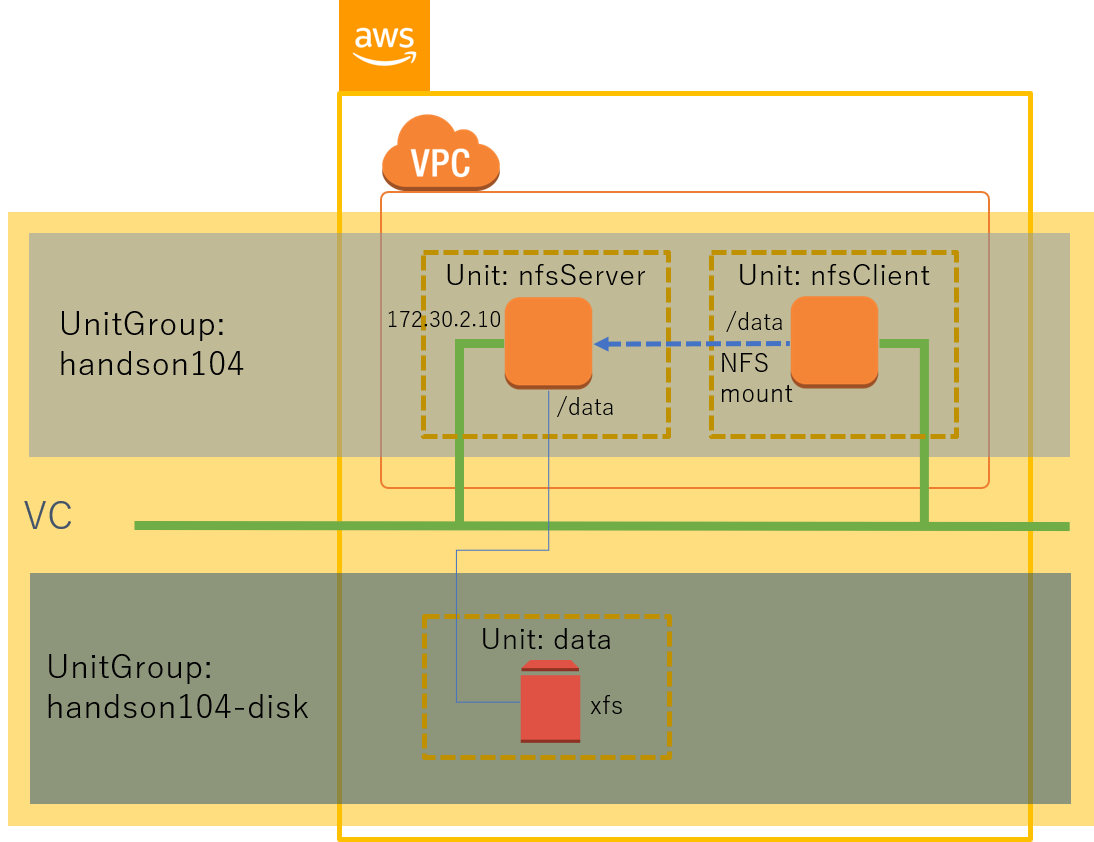

## 初期設定

NFSクライアント用のVCノードは標準のBaseコンテナイメージを用いているのでNFS関連の設定が行われていません。必要となる初期設定をここで行います。

まずNFSドメインの設定を/etc/idmapd.confに行います。NFSドメインの値は NFSサーバを設定したときの変数`nfs_domain`に格納されている値をそのまま用います。

In [55]:
!ansible {unit_client.name} -b \
    -a 'sed -ri "s/^#?\s*Domain\s*=.*/Domain = {nfs_domain}/" /etc/idmapd.conf'

 [WARNING]: Consider using template or lineinfile module rather than running
sed

172.30.2.143 | SUCCESS | rc=0 >>




/etc/idmapd.conf のドメイン設定が更新されていることを確認します。

In [56]:
!ansible {unit_client.name} -b \
    -a 'egrep -e "^#?\s*Domain\s*=" /etc/idmapd.conf'

172.30.2.143 | SUCCESS | rc=0 >>
Domain = vcp-handson.org



rpc_pipefs を /var/lib/nfs/rpc_pipefsにマウントします。

In [57]:
!ansible {unit_client.name} -b -m mount \
    -a 'path=/var/lib/nfs/rpc_pipefs fstype=rpc_pipefs state=mounted src=none'

172.30.2.143 | SUCCESS => {
    "changed": true, 
    "dump": "0", 
    "failed": false, 
    "fstab": "/etc/fstab", 
    "fstype": "rpc_pipefs", 
    "name": "/var/lib/nfs/rpc_pipefs", 
    "opts": "defaults", 
    "passno": "0", 
    "src": "none"
}


## NFSマウント

`/data` にNFSマウントします。

In [58]:
!ansible {unit_client.name} -b -m mount \
    -a 'path=/data src=172.30.2.10:/ state=mounted fstype=nfs opts=nfsvers=4'

172.30.2.143 | SUCCESS => {
    "changed": true, 
    "dump": "0", 
    "failed": false, 
    "fstab": "/etc/fstab", 
    "fstype": "nfs", 
    "name": "/data", 
    "opts": "nfsvers=4", 
    "passno": "0", 
    "src": "172.30.2.10:/"
}


マウントされたことを確認します。

In [59]:
!ansible {unit_client.name} -m shell -a 'mount | grep /data'

 [WARNING]: Consider using mount module rather than running mount

172.30.2.143 | SUCCESS | rc=0 >>
172.30.2.10:/ on /data type nfs4 (rw,relatime,vers=4.0,rsize=1048576,wsize=1048576,namlen=255,hard,proto=tcp,timeo=600,retrans=2,sec=sys,clientaddr=172.30.2.143,local_lock=none,addr=172.30.2.10)



## ファイルの作成

NFSマウントした `/data` （NFSクライアント側）でファイルを作成してみます。

### ユーザの作成

NFSの場合 `root` 権限でファイルの書き込みを行うと squash の機能により所有者が `nobody` になってしまい扱いづらいので、一般ユーザ`vcp`を作成します。

NFSサーバ、NFSクライアントそれぞれで `vcp` という名前のユーザを作成します。

In [60]:
!ansible {unit_client.name} -b -a 'adduser -D vcp'
!ansible {unit_server.name} -b -a 'adduser -D vcp'

172.30.2.143 | SUCCESS | rc=0 >>


172.30.2.10 | SUCCESS | rc=0 >>




作成したユーザ権限でコマンドが実行できることを確認するために `id`コマンドを実行してみます。

> ansibleで別のユーザ権限でコマンドを実行するには --become-user にユーザ名を指定します。

In [61]:
# 別のユーザ権限に変更するためのオプションを変数に設定しておく
become_opts = '-b --become-user=vcp --become-method=su'

# id コマンドを実行して一般ユーザ(vcp)権限でコマンドが実行できることを確認する
!ansible {unit_client.name} {become_opts} -a 'id'
!ansible {unit_server.name} {become_opts} -a 'id'

172.30.2.143 | SUCCESS | rc=0 >>
uid=1000(vcp) gid=1000(vcp) groups=1000(vcp)

172.30.2.10 | SUCCESS | rc=0 >>
uid=1000(vcp) gid=1000(vcp) groups=1000(vcp)



### ファイルの作成

ファイルに書き込む内容を変数に設定します。

In [62]:
text = '''
この Notebook では以下の操作を行います。

1. VCP SDKを用いてVCディスク(Amazon EBS)を作成する
2. 作成したVCディスクをアタッチしたVCノード(Amazon EC2)を起動する
3. VCディスクにファイルシステムを作成しNFSサーバで公開する
4. NFSで公開されているディレクトリを他のVCノードからNFSマウントして、ファイルの読み書きを行う
5. VCノードを全て削除する
6. VCディスクをアタッチしたVCノードを新たに起動して、先ほど書き込んだファイルにアクセスできることを確認する
'''

NFSクライアント側で `/data/text` というファイルに先ほどの内容を書き込みます。書き込む際のユーザ権限は先ほど設定した `become_opts` の指定で一般ユーザ `vcp` に変更します。ファイルの書き込みには、リモート環境にあるファイルの内容を書き換えることができる Ansible の [blockinfile モジュール](https://docs.ansible.com/ansible/latest/modules/blockinfile_module.html)を利用します。
blockinfileモジュールの簡単な使用方法を以下に記します。詳細についてはリンク先の[公式ドキュメント](https://docs.ansible.com/ansible/latest/modules/blockinfile_module.html)を参照してください。


```
ansible <ホストパターン> -m blockinfile -a 'path=<path> owner=<owner> create=<no|yes> block=<content>'

blockinfileモジュールのパラメータ(-a)について:
path
      更新対象となるリモート環境のファイル
owner
      更新対象のファイルのオーナー
create
      ファイルが存在しない場合、作成するか否か
      yes を設定するとファイルが存在しない場合でもファイルを作成して内容の変更を行う
      no を設定するとファイルが存在しない場合は何もしない(デフォルト)
block
      ファイルに書き込む内容
```

In [63]:
!ansible {unit_client.name} {become_opts} -m blockinfile \
    -a 'path=/data/text owner=vcp create=yes block="{text}"'

172.30.2.143 | SUCCESS => {
    "changed": true, 
    "failed": false, 
    "msg": "File created"
}


ファイルが作成されたことを確認するためにNFSクライアント側で `ls -l /data`, `cat /data/text` を実行してみます。

In [64]:
!ansible {unit_client.name} -a 'ls -la /data'

172.30.2.143 | SUCCESS | rc=0 >>
total 8
drwxrwxrwt    2 root     root            18 Sep 28 06:37 .
drwxr-xr-x   62 root     root          4096 Sep 28 06:37 ..
-rw-r--r--    1 vcp      vcp            682 Sep 28 06:37 text



In [65]:
!ansible {unit_client.name} -a 'cat /data/text'

172.30.2.143 | SUCCESS | rc=0 >>
# BEGIN ANSIBLE MANAGED BLOCK

この Notebook では以下の操作を行います。

1. VCP SDKを用いてVCディスク(Amazon EBS)を作成する
2. 作成したVCディスクをアタッチしたVCノード(Amazon EC2)を起動する
3. VCディスクにファイルシステムを作成しNFSサーバで公開する
4. NFSで公開されているディレクトリを他のVCノードからNFSマウントして、ファイルの読み書きを行う
5. VCノードを全て削除する
6. VCディスクをアタッチしたVCノードを新たに起動して、先ほど書き込んだファイルにアクセスできることを確認する
# END ANSIBLE MANAGED BLOCK



NFSサーバ側でも同様の確認を行ってみます。

In [66]:
!ansible {unit_server.name} -a 'ls -la /data'

172.30.2.10 | SUCCESS | rc=0 >>
total 8
drwxrwxrwt    2 root     root            18 Sep 28 06:37 .
drwxr-xr-x   70 root     root          4096 Sep 28 06:37 ..
-rw-r--r--    1 vcp      vcp            682 Sep 28 06:37 text



In [67]:
!ansible {unit_server.name} -a 'cat /data/text'

172.30.2.10 | SUCCESS | rc=0 >>
# BEGIN ANSIBLE MANAGED BLOCK

この Notebook では以下の操作を行います。

1. VCP SDKを用いてVCディスク(Amazon EBS)を作成する
2. 作成したVCディスクをアタッチしたVCノード(Amazon EC2)を起動する
3. VCディスクにファイルシステムを作成しNFSサーバで公開する
4. NFSで公開されているディレクトリを他のVCノードからNFSマウントして、ファイルの読み書きを行う
5. VCノードを全て削除する
6. VCディスクをアタッチしたVCノードを新たに起動して、先ほど書き込んだファイルにアクセスできることを確認する
# END ANSIBLE MANAGED BLOCK



# VCノードの削除

作成したVCノードをいったん全て削除します。

この節を実行すると次図の状態になります。

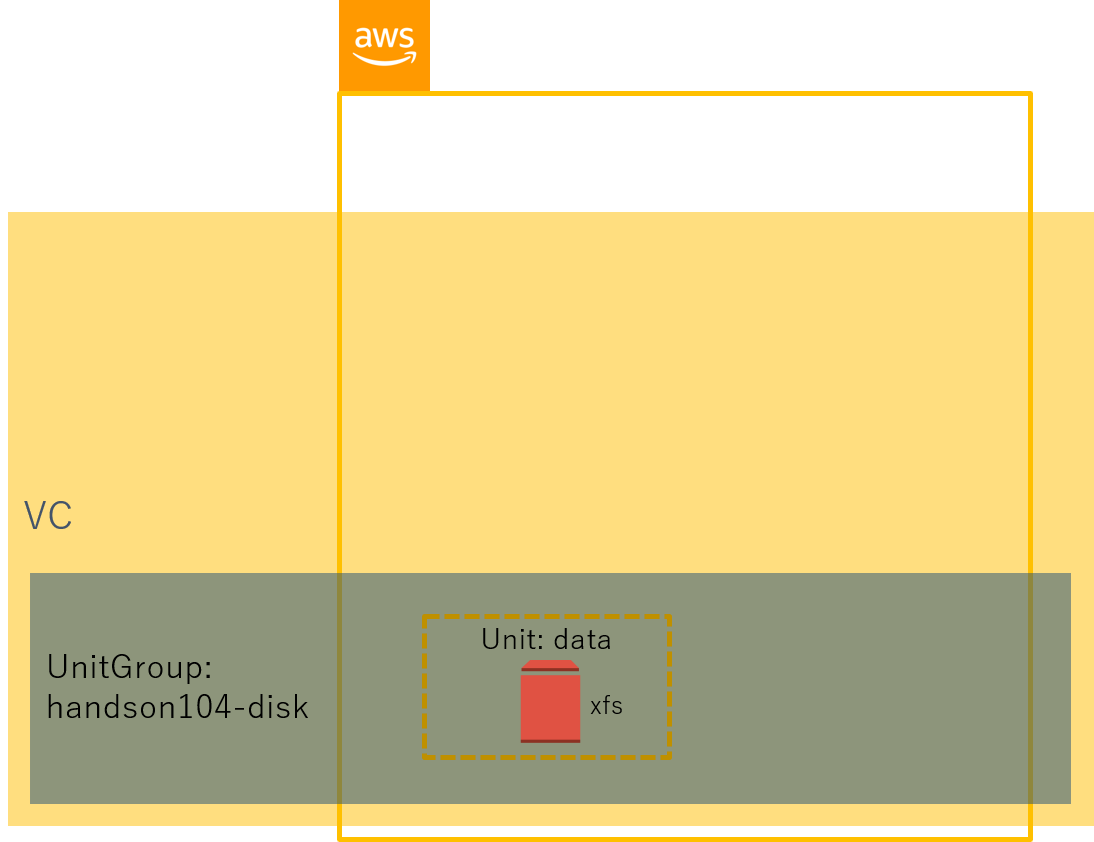

VCノードを削除するまえにNFSのアンマウントを行います。

In [68]:
!ansible {unit_client.name} -b -m mount \
    -a 'path=/data src=172.30.2.10:/ state=unmounted fstype=nfs opts=nfsvers=4'

172.30.2.143 | SUCCESS => {
    "changed": true, 
    "dump": "0", 
    "failed": false, 
    "fstab": "/etc/fstab", 
    "fstype": "nfs", 
    "name": "/data", 
    "opts": "nfsvers=4", 
    "passno": "0", 
    "src": "172.30.2.10:/"
}


NFSサーバのVCノードではVCディスクのアンマウントを行います。

In [69]:
# 全てのディレクトリをアンエクスポートする
!ansible {unit_server.name} -b -a 'exportfs -ua'

# アンマウントを行う
!ansible {unit_server.name} -b -m mount \
    -a 'path=/data src=LABEL=nfs-data state=unmounted fstype=xfs'

172.30.2.10 | SUCCESS | rc=0 >>


172.30.2.10 | SUCCESS => {
    "changed": true, 
    "dump": "0", 
    "failed": false, 
    "fstab": "/etc/fstab", 
    "fstype": "xfs", 
    "name": "/data", 
    "opts": "defaults", 
    "passno": "0", 
    "src": "LABEL=nfs-data"
}


`handson104` に属している全てのVCノードを削除します。

> 処理が完了するまで1分半～2分程度かかります。

In [70]:
unit_group.cleanup()

2018-09-28 15:38:32,114 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 0 sec
2018-09-28 15:38:37,413 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 5 sec
2018-09-28 15:38:42,710 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 10 sec
2018-09-28 15:38:48,027 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 15 sec
2018-09-28 15:38:53,325 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 20 sec
2018-09-28 15:38:58,616 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 25 sec
2018-09-28 15:39:03,906 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 30 sec
2018-09-28 15:39:09,198 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 35 sec
2018-09-28 15:39:14,496 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 40 sec
2018-09-28 15:39:19,801 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 45 sec
2018-09-28 15:39:25,107 - INFO - nfsServer is DELETING
nfsClient is DELETING ... 50 sec
2018-09-28 15:39:30,367 - INFO - n

削除後の状態を確認してみます。

In [71]:
vcp.df_ugroups()

,vcno,vctype,vcname,state,vcid,cdate
0,39,storage,handson104-disk,RUNNING,9a906c6d...,2018/09/28 06:29:02 UTC


# 新たなVCノードにVCディスクを再びアタッチする

この節を実行すると次の図の状態になります。

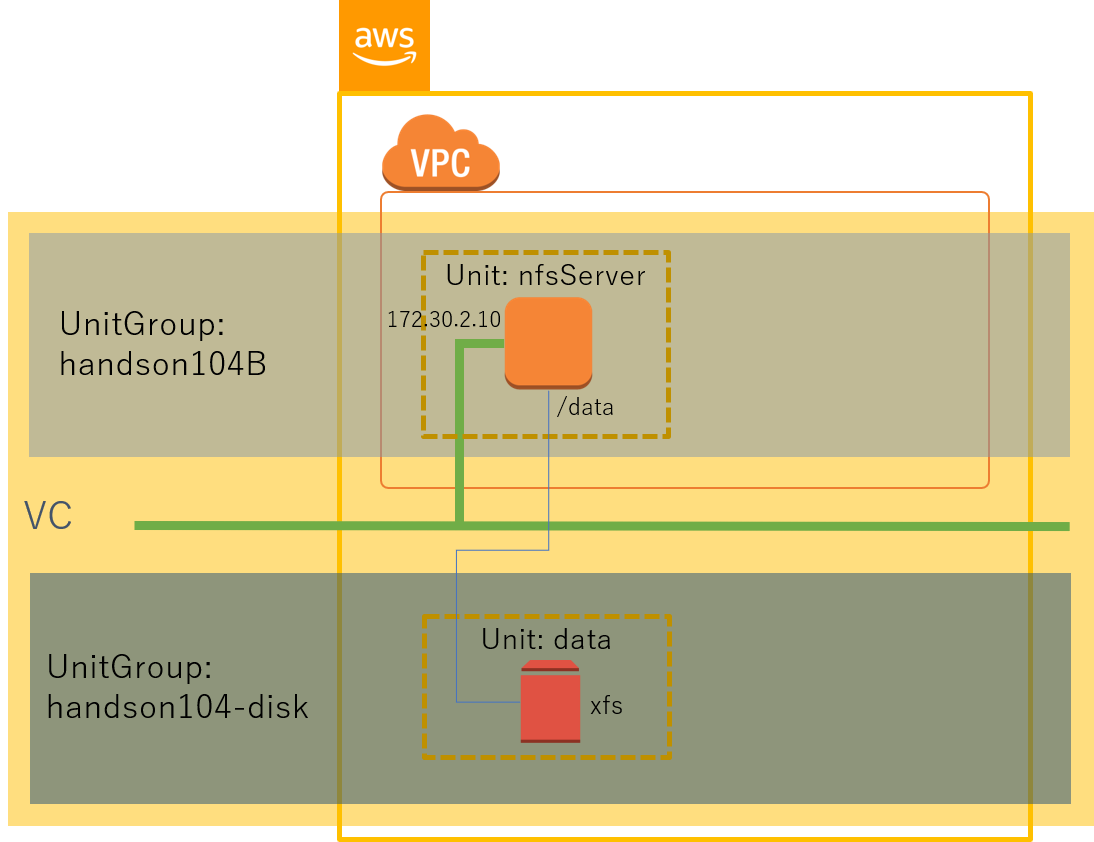

## VCノードの起動

### UnitGroupの作成

VCノード用のUnitGroupを新たに作成します。

In [72]:
unit_group2 = vcp.create_ugroup('handson104B')

### VCノードのspecを指定する

VCディスクをアタッチするVCノードのUnitを構成します。基本的にはNFSサーバ用のUnitと同じ設定を `spec`オブジェクトに対して行います。

#### spec オブジェクトを作成する

Unitに対応する specオブジェクトを作成します。ここでは以下の値を指定します。

* プロバイダ: `aws`
* flavor: `small`

In [73]:
spec_server2 = VcpSDK.get_spec('aws', 'small')

#### sshの鍵ファイルを設定する

VCノードに登録するsshの公開鍵を `spec`オブジェクトに設定します。先ほどNFSサーバ用Unitで設定したのと同じ値を指定しています。

In [74]:
spec_server2.params_e.append('AUTHORIZED_KEYS={}'.format(b64_ssh_public_key))

#### VCノードのIPアドレスを設定する

先ほどNFSサーバ用Unitで設定したのと同じIPアドレスを`spec`オブジェクトに指定します。

In [75]:
spec_server2.ip_address_list = [server_ip_address]

#### VCディスクをアタッチする

先ほどNFSサーバ用Unitで設定したのと同じボリュームIDを`spec`オブジェクトに指定します。

In [76]:
spec_server2.volume_id = volume_id

#### NFSサーバ用のBaseコンテナに関する設定を行う

先ほどNFSサーバ用Unitで設定したのと同じBaseコンテナイメージを`spec`オブジェクトに指定します。

In [77]:
# NFSサーバ用のコンテナイメージを設定する
spec_server2.image = 'nfsd'

先ほどNFSサーバ用Unitで設定したのとNFSドメインの値を`spec`オブジェクトに指定します。

In [78]:
spec_server2.params_e.append('NFS_DOMAIN={}'.format(nfs_domain))

NFSサーバの /etc/fstab, /etc/exports は VCノード を削除したときに同時に削除されています。先程と同等の /etc/fstab, /etc/exports を復元するには Baseコンテナの環境変数として与える必要があります。

まず NFSサーバの /etc/fstab に関する設定を行います。/etc/fstabに関するBaseコンテナの環境変数の設定方法は以下のようになっています。

* ETC_FSTAB
  - 指定された値を/etc/fstabに反映する。ただしbase64エンコードした値を指定する必要がある
  
設定する /etc/fstab の内容を変数に設定します。

> /etc/fstab の設定内容は先ほどNFSサーバを設定した箇所の実行記録で確認できます。

In [79]:
fstab = 'LABEL=nfs-data /data xfs defaults 0 0'

`fstab`の内容を base64エンコードして `ETC_FSTAB` に設定します。

In [80]:
import base64
spec_server2.params_e.append('ETC_FSTAB={}'.format(
    base64.b64encode(fstab.encode('UTF-8')).decode('UTF-8')))

次に /etc/exports に関する設定を行います。/etc/exportsに関するBaseコンテナの環境変数の設定方法は以下のようになっています。

* ETC_EXPORTS
  - 指定された値を/etc/exportsに反映する。ただしbase64エンコードした値を指定する必要がある
  
/etc/exports の記述内容は、先ほどNFSサーバを設定した際に変数 `exports` に格納してあるので、その内容を確認してみます。

In [81]:
exports

'/data 172.30.2.0/24(rw,fsid=0,no_subtree_check)'

`exports`の内容を base64エンコードして `ETC_EXPORTS` に設定します。

In [82]:
spec_server2.params_e.append('ETC_EXPORTS={}'.format(
    base64.b64encode(exports.encode('UTF-8')).decode('UTF-8')))

最後にマウントポイントになるディレクトリ `/data` を事前に作成するために環境変数 `MKDIR_LIST` の設定を行います。

* MKDIR_LIST
  - 指定されたディレクトリを起動時に作成する
  - 複数のディレクトリを指定する場合は `:` で区切る
  - マウントポイントなど事前にディレクトリが存在する必要がある場合に指定する

In [83]:
spec_server2.params_e.append('MKDIR_LIST=/data')

#### specの設定内容の確認

ここまで `spec` オブジェクトに設定した内容を確認してみます。

In [84]:
print(spec_server2)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: nfsd
    recovery_mode: none
    params:
        {'v': [], 'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK', 'NFS_DOMAIN=vcp-handson.org', 'ETC_FSTAB=TEFCRUw9bmZzLWRhdGEgL2RhdGEgeGZzIGRlZmF1bHRzIDAgMA==', 'ETC_EXPORTS=L2RhdGEgMTcyLjMwLjIuMC8yNChydyxmc2lkPTAsbm9fc3VidHJlZV9jaGVjayk=', 'MKDIR_LIST=/data']}
    instance_type: m4.large
    volume_size: 20
    volume_type: stand

### Unitの作成とVCノードの起動

起動前のUnit, Nodeの状態を確認しておきます。

In [85]:
# Unitの一覧を DataFrame で表示する
display(unit_group2.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group2.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


None

Unitの作成とVCノードの起動を行います。

> 処理が完了するまで1分半～2分程度かかります。

In [86]:
# Unitの作成（同時に VCノードが作成される）
unit_server = unit_group2.create_unit('nfsServer', spec_server2)

2018-09-28 15:40:35,183 - INFO - BOOTING ... 0 sec
2018-09-28 15:40:40,390 - INFO - BOOTING ... 5 sec
2018-09-28 15:40:45,598 - INFO - BOOTING ... 10 sec
2018-09-28 15:40:50,797 - INFO - BOOTING ... 15 sec
2018-09-28 15:40:55,996 - INFO - BOOTING ... 20 sec
2018-09-28 15:41:01,207 - INFO - BOOTING ... 25 sec
2018-09-28 15:41:06,398 - INFO - BOOTING ... 30 sec
2018-09-28 15:41:11,592 - INFO - BOOTING ... 35 sec
2018-09-28 15:41:16,797 - INFO - BOOTING ... 40 sec
2018-09-28 15:41:21,990 - INFO - BOOTING ... 45 sec
2018-09-28 15:41:27,176 - INFO - BOOTING ... 50 sec
2018-09-28 15:41:32,367 - INFO - BOOTING ... 55 sec
2018-09-28 15:41:37,567 - INFO - BOOTING ... 60 sec
2018-09-28 15:41:42,778 - INFO - BOOTING ... 65 sec
2018-09-28 15:41:47,978 - INFO - BOOTING ... 70 sec
2018-09-28 15:41:53,193 - INFO - BOOTING ... 75 sec
2018-09-28 15:41:58,398 - INFO - BOOTING ... 80 sec
2018-09-28 15:42:03,616 - INFO - unit nfsServer is RUNNING


起動したUnit, VCノードの一覧を表示します。

In [87]:
# Unitの一覧を DataFrame で表示する
display(unit_group2.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group2.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,41,handson104B,RUNNING,eb13b412...,2018/09/28 06:39:13 UTC,nfsServer,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,41,handson104B,nfsServer,RUNNING,1,6c2ae4d8...,RUNNING,172.30.2.10,i-09dd361b661fd2290,VCP-020661f0-eb13b412,exists


## VCディスクの内容を確認する

先程NFSクライアントで作成したファイルにアクセスできるか確認してみます。

In [88]:
!ansible {unit_server.name} -a 'ls -la /data'

172.30.2.10 | SUCCESS | rc=0 >>
total 8
drwxrwxrwt    2 root     root            18 Sep 28 06:37 .
drwxr-xr-x   69 root     root          4096 Sep 28 06:41 ..
-rw-r--r--    1 1000     1000           682 Sep 28 06:37 text



In [89]:
!ansible {unit_server.name} -a 'cat /data/text'

172.30.2.10 | SUCCESS | rc=0 >>
# BEGIN ANSIBLE MANAGED BLOCK

この Notebook では以下の操作を行います。

1. VCP SDKを用いてVCディスク(Amazon EBS)を作成する
2. 作成したVCディスクをアタッチしたVCノード(Amazon EC2)を起動する
3. VCディスクにファイルシステムを作成しNFSサーバで公開する
4. NFSで公開されているディレクトリを他のVCノードからNFSマウントして、ファイルの読み書きを行う
5. VCノードを全て削除する
6. VCディスクをアタッチしたVCノードを新たに起動して、先ほど書き込んだファイルにアクセスできることを確認する
# END ANSIBLE MANAGED BLOCK



> ユーザ`vcp`に関する情報が削除されているので、所有者に関する情報がユーザ名ではなく UID:GID になっています。ユーザ情報などは外部の（あるいは別UnitGroupに構築した）LDAPサーバなどに格納することが望ましいです。

# 後始末

これまでに作成した全てのリソースを削除します。

> 処理が完了するまで1分～2分程度かかります。

In [90]:
# VCノードの削除
unit_group2.cleanup()

# VCディスクの削除
ugroup_disk.cleanup()

2018-09-28 15:42:31,343 - INFO - nfsServer is DELETING ... 0 sec
2018-09-28 15:42:36,591 - INFO - nfsServer is DELETING ... 5 sec
2018-09-28 15:42:41,841 - INFO - nfsServer is DELETING ... 10 sec
2018-09-28 15:42:47,084 - INFO - nfsServer is DELETING ... 15 sec
2018-09-28 15:42:52,324 - INFO - nfsServer is DELETING ... 20 sec
2018-09-28 15:42:57,563 - INFO - nfsServer is DELETING ... 25 sec
2018-09-28 15:43:02,803 - INFO - nfsServer is DELETING ... 30 sec
2018-09-28 15:43:08,052 - INFO - nfsServer is DELETING ... 35 sec
2018-09-28 15:43:13,293 - INFO - nfsServer is DELETING ... 40 sec
2018-09-28 15:43:18,543 - INFO - nfsServer is DELETING ... 45 sec
2018-09-28 15:43:23,814 - INFO - nfsServer is DELETING ... 50 sec
2018-09-28 15:43:29,032 - INFO - cleanup completed. vc handson104B is cleanup(no unit)
2018-09-28 15:43:29,425 - INFO - data is DELETING ... 0 sec
2018-09-28 15:43:34,643 - INFO - data is DELETING ... 5 sec
2018-09-28 15:43:39,832 - INFO - cleanup completed. vc handson104-dis

削除後の状態を確認します。

In [91]:
# UnitGroupの一覧を DataFrame で表示する
vcp.df_ugroups()

,vcno,vctype,vcname,state,vcid,cdate


不要になったインベントリファイルを削除します。

In [92]:
!rm hosts